In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import seaborn as sns
import numpy as np
import joypy
import datetime
from bokeh.plotting import figure, output_file, show
%matplotlib inline

In [2]:
OTP_data=pd.read_pickle(r"/Users/brianparker/Work/OTP_pickle.pkl")
OTP_data=pd.DataFrame(OTP_data)

In [3]:
OTP_data.dropna(axis=1,how='all',inplace=True)

In [4]:
OTP_data.drop(['MinutesEarly','MinutesLate','Group1Type','Group1','Group2Type','Group3Type','Group2','Group3','EarlyStop','LateStop','EarlyThreshold','LateThreshold','AgencyDescription'],axis=1,inplace=True)

In [5]:
OTP_data['Relative']=OTP_data['DepartTime']-OTP_data['ScheduledStopTime']

In [6]:
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>"02:00:00",OTP_data['Relative']<"-01:00:00"),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [7]:
OTP_data=OTP_data[OTP_data.Invalid==False]

In [8]:
OTP_data.drop(['Invalid'],axis=1,inplace=True)

In [9]:
OTP_data['Early']=np.where(OTP_data['Relative']<"-00:01:00",True,False)

In [10]:
OTP_data['Late']=np.where(OTP_data['Relative']>"00:05:00",True,False)

In [11]:
OTP_data['OnTime']=np.logical_and(OTP_data['Early']==False,OTP_data['Late']==False)
OTP_data['Terminal']=np.where(np.logical_or(OTP_data['ScheduledTripStart']==OTP_data['ScheduledStopTime'],OTP_data['ScheduledTripEnd']==OTP_data['ScheduledStopTime']),True,False)

In [12]:
on_time=OTP_data[OTP_data.OnTime==True]
early=OTP_data[OTP_data.Early==True]
late=OTP_data[OTP_data.Late==True]

In [13]:
OTP_data['date']=OTP_data['ScheduledStopTime'].dt.date
OTP_data['time']=OTP_data['ScheduledStopTime'].dt.time

In [14]:
OTP_data['hour']=[r.hour for r in OTP_data.time]

In [15]:
OTP_data['RelNum']=(pd.to_numeric(OTP_data['Relative'],downcast='integer'))/60000000000
OTP_data.head()

,MasterRouteName,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime,Relative,Early,Late,OnTime,Terminal,date,time,hour,RelNum
0,Route 10 Hill Road,R10_06:45_Weekday_70582,Gary & Bunch,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 06:45:00,2018-02-14 07:11:00,39,2018-02-14 07:11:00,2018-02-14 07:11:45,2018-02-14 07:11:45,00:00:45,False,False,True,True,2018-02-14,07:11:00,7,0.750000
1,Route 10 Hill Road,R10_08:00_Weekday_70587,Gary & Bunch,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,1,2018-02-14 08:00:01,2018-02-14 08:08:39,2018-02-14 08:09:16,00:09:15,False,True,False,True,2018-02-14,08:00:01,8,9.250000
2,Route 10 Hill Road,R10_08:00_Weekday_70587,Tobi & Pierce Park,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,5,2018-02-14 08:07:00,2018-02-14 08:13:28,2018-02-14 08:14:14,00:07:14,False,True,False,False,2018-02-14,08:07:00,8,7.233333
3,Route 10 Hill Road,R10_08:00_Weekday_70587,Hill & Collister,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,12,2018-02-14 08:14:00,2018-02-14 08:17:22,2018-02-14 08:17:57,00:03:57,False,False,True,False,2018-02-14,08:14:00,8,3.950000
4,Route 10 Hill Road,R10_08:00_Weekday_70587,Taft & 28th,BRIAN FR BRESHEARS,2018-02-14,2018-02-14 08:00:01,2018-02-14 08:40:00,23,2018-02-14 08:21:00,2018-02-14 08:25:12,2018-02-14 08:25:45,00:04:45,False,False,True,False,2018-02-14,08:21:00,8,4.750000


In [16]:
by_route=OTP_data.groupby(['MasterRouteName','hour'])

In [17]:
by_route_early=by_route.Early.sum()
by_route_ontime=by_route.OnTime.sum()
by_route_late=by_route.Late.sum()

In [18]:
by_route_df=pd.DataFrame([by_route_early,by_route_ontime,by_route_late]).T

In [19]:
#by_route_df.sort_values('Early',ascending=False).plot(kind='bar',title='VRT On-Time Trips')

In [20]:
cols=['Early','Late','OnTime']
by_route_df['Early_pct']=(by_route_df['Early']/by_route_df[cols].sum(axis=1))*100
by_route_df['OnTime_pct']=(by_route_df['OnTime']/by_route_df[cols].sum(axis=1))*100
by_route_df['Late_pct']=(by_route_df['Late']/by_route_df[cols].sum(axis=1))*100

In [21]:
by_route_df.reset_index(inplace=True)

In [22]:
heat=by_route_df.pivot("hour","MasterRouteName","OnTime_pct")
ridge=by_route_df.pivot("MasterRouteName","hour","Late_pct")
ridge.reset_index(inplace=True)
heat.reset_index(inplace=True)
ridge.head()

hour,MasterRouteName,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,Route 1 Parkcenter,12.291667,27.767115,46.297594,45.071412,50.500217,45.151954,45.542169,54.733301,52.735849,46.065808,52.417178,54.374255,56.533531,39.589095,NaN,NaN,NaN,NaN
1,Route 10 Hill Road,8.226950,11.111111,20.107323,27.555397,22.311047,18.191643,21.877283,35.578387,34.437826,42.262343,60.139603,70.592620,69.763957,51.729560,28.228688,NaN,NaN,NaN
2,Route 11 Garden City,NaN,NaN,NaN,NaN,5.175601,30.646449,21.834416,25.835371,27.927928,28.809524,45.174825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Route 12 Maple Grove,20.967742,13.890072,41.136267,43.671706,38.180235,37.951807,43.337702,48.460862,57.540911,55.935173,78.119430,78.144514,84.162483,50.509956,25.740898,NaN,NaN,NaN
4,Route 14 Hyde Park,1.204819,19.034954,23.406634,24.780850,27.513465,23.782235,23.826291,19.000581,29.466357,25.707683,26.874003,22.417355,28.990826,23.722628,NaN,NaN,NaN,NaN


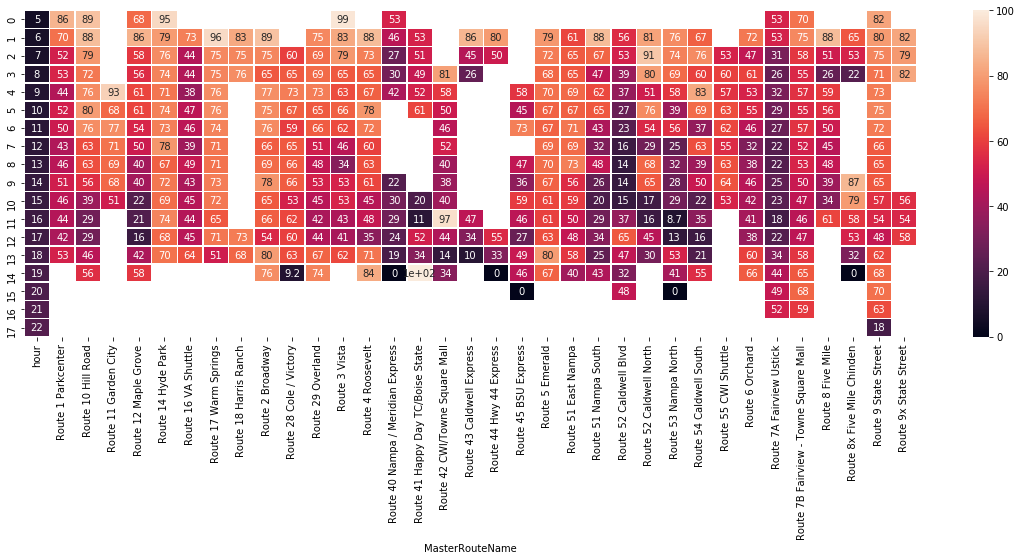

In [23]:
f, ax=plt.subplots(figsize=(20,6))
sns.heatmap(heat,annot=True,linewidths=.5,ax=ax)

In [24]:
by_date=OTP_data.groupby(['MasterRouteName','date'])
by_date_early=by_date.Early.sum()
by_date_ontime=by_date.OnTime.sum()
by_date_late=by_date.Late.sum()

In [25]:
by_date_df=pd.DataFrame([by_date_early,by_date_ontime,by_date_late]).T

In [26]:
by_date_df['Early_pct']=(by_date_df['Early']/by_date_df[cols].sum(axis=1))*100
by_date_df['OnTime_pct']=(by_date_df['OnTime']/by_date_df[cols].sum(axis=1)*100)
by_date_df['Late_pct']=(by_date_df['Late']/by_date_df[cols].sum(axis=1)*100)
by_date_df.reset_index(inplace=True)

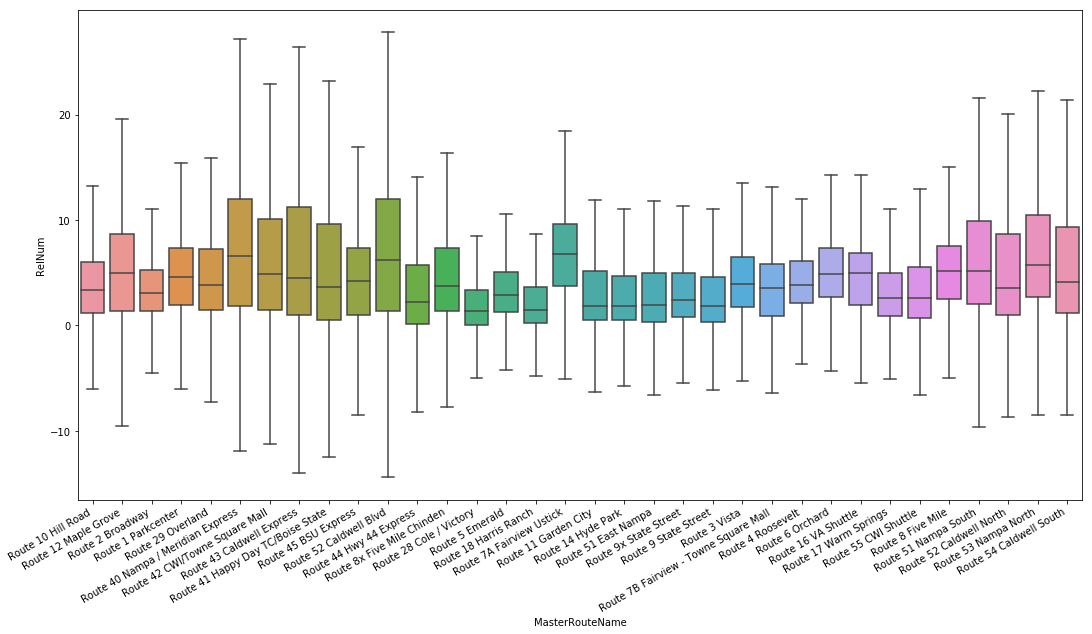

In [32]:
fig, ax=plt.subplots(figsize=(18,10))
sns.boxplot(OTP_data.MasterRouteName,OTP_data.RelNum,ax=ax,showfliers=False)
fig.autofmt_xdate()